# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [23]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [9]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)


- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

### Solution

In [17]:
# Loading the bike dataset
bike_train = pd.read_csv('Bikeshare_train.csv').drop('Unnamed: 0',axis=1)
bike_test = pd.read_csv('Bikeshare_test.csv').drop('Unnamed: 0',axis=1)

# Transforms the categoricals variables in binary ones by dummies operation 
categorical_columns_g2cols = ['season', 'month', 'day_of_week', 'weather']
bike_train = pd.get_dummies(bike_train,columns=categorical_columns_g2cols,drop_first=True)
bike_test = pd.get_dummies(bike_test,columns=categorical_columns_g2cols,drop_first=True)

# Normalizes the continues variables
mean = bike_train['count'].mean()
std = bike_train['count'].std()
bike_train['count'] = (bike_train['count']-mean)/std
bike_test['count'] = (bike_test['count']-mean)/std


Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 



In [59]:
from sklearn.model_selection import KFold

# Sample the data
def sample_data(sample):
    n = bike_train.shape[0]
    random_index =  np.random.choice(np.arange(n),sample)

    train_sub = bike_train.iloc[random_index]
    y_train_sub = train_sub['count'].values.reshape(-1,1)
    train_sub = train_sub.drop('count',axis = 1)
    
    Xtest = bike_test.drop('count',axis=1)
    ytest = bike_test['count'].values.reshape(-1,1)
    return train_sub,Xtest,y_train_sub,ytest

def select_lambda(model,train_sub,y_train_sub):
    n_folds = 5
    splits = train_sub.shape[0]
    kfold = KFold(n_folds,shuffle=False).split(range(splits))

    scores = []
    for f_train,f_valid in kfold:
        ktrain = train_sub.values[f_train]
        kvalid = train_sub.values[f_valid]    
        
        ky_train = y_train_sub[f_train]
        ky_valid = y_train_sub[f_valid]   
        score = []
        for lamb in lambdas:
            rid_model = model(alpha = lamb)
            rid_model.fit(ktrain,ky_train)
            y_pred = rid_model.predict(kvalid)
            score.append(r2_score(ky_valid,y_pred))
        scores.append(score)
            
    valid_score = np.array(scores).mean(axis=0)
    cvstd = np.array(scores).std(axis=0)
    beststd = cvstd[np.argmax(valid_score)]
    best_lambd = lambdas[np.argmax(valid_score)]
    return valid_score,best_lambd,beststd



C:\Users\Lira\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Ridge Train Score:  0.572729580884
Ridge CV interval:0.35422444803-0.633626299377
Ridge Test Score:  0.186300864401

Lasso Train Score:  0.553408763148
Lasso CV interval:0.337123904978-0.632339078546
Lasso Test Score:  0.21361519113


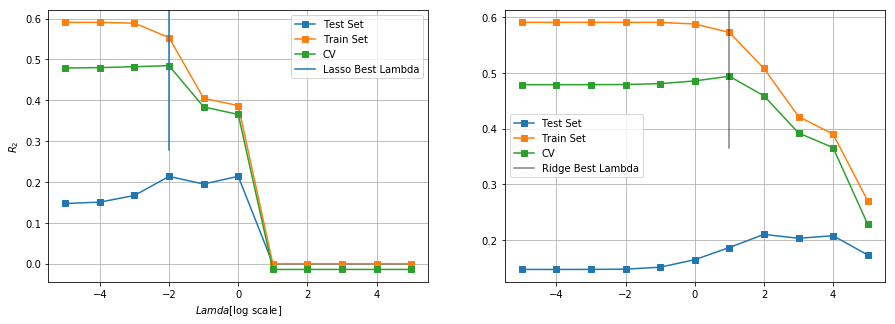

In [65]:
# Select the best lambda and fits the models

lambdas = [10**i for i in range(-5,6)]
train_sub,Xtest,y_train_sub,y_test = sample_data(400)

ridge_valid_score,ridge_best_lambda,rcv_std = select_lambda(Ridge,train_sub,y_train_sub)
lasso_valid_score,lasso_best_lambda,lcv_std = select_lambda(Lasso,train_sub,y_train_sub)

ridge_model = Ridge(alpha=ridge_best_lambda)
ridge_model.fit(train_sub,y_train_sub)
train_score = r2_score(y_train_sub,ridge_model.predict(train_sub))
test_score = r2_score(y_test,ridge_model.predict(Xtest))
print('Ridge Train Score: ',train_score)
#print('Ridge CV Score: ',np.max(ridge_valid_score) )
print('Ridge CV interval:'+str(np.max(ridge_valid_score)-2*rcv_std)+"-"+str(np.max(ridge_valid_score)+2*rcv_std))
print('Ridge Test Score: ',test_score)
print('')

lasso_model = Lasso(alpha=lasso_best_lambda)
lasso_model.fit(train_sub,y_train_sub)
train_score = r2_score(y_train_sub,lasso_model.predict(train_sub))
test_score = r2_score(y_test,lasso_model.predict(Xtest))
print('Lasso Train Score: ',train_score)
print('Lasso CV interval:'+str(np.max(lasso_valid_score)-2*lcv_std)+"-"+str(np.max(lasso_valid_score)+2*lcv_std))
print('Lasso Test Score: ',test_score)

ltrain_score = []
ltest_score = []
rtrain_score = []
rtest_score = []
for lambd in lambdas:
    lmodel = Lasso(alpha=lambd)
    lmodel.fit(train_sub,y_train_sub)
    ltrain_pred = lmodel.predict(train_sub)
    ltrain_score.append(r2_score(y_train_sub,ltrain_pred))    
    ltest_pred = lmodel.predict(Xtest)
    ltest_score.append(r2_score(y_test,ltest_pred))
    
    rmodel = Ridge(alpha=lambd)
    rmodel.fit(train_sub,y_train_sub)
    rtrain_pred = rmodel.predict(train_sub)
    rtrain_score.append(r2_score(y_train_sub,rtrain_pred))    
    rtest_pred = rmodel.predict(Xtest)
    rtest_score.append(r2_score(y_test,rtest_pred))
    

fig,ax= plt.subplots(1,2,figsize=(15,5))
ax[0].plot(np.log10(lambdas),ltest_score,'s-',label='Test Set')
ax[0].plot(np.log10(lambdas),ltrain_score,'s-',label='Train Set')
ax[0].plot(np.log10(lambdas),lasso_valid_score,'s-',label='CV')
ax[0].axvline(np.log10(lasso_best_lambda),max(lasso_valid_score),label='Lasso Best Lambda')
ax[0].set_xlabel('$Lamda$[log scale]')
ax[0].set_ylabel('$R_2$')
ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(np.log10(lambdas),rtest_score,'s-',label='Test Set')
ax[1].plot(np.log10(lambdas),rtrain_score,'s-',label='Train Set')
ax[1].plot(np.log10(lambdas),ridge_valid_score,'s-',label='CV')
ax[1].axvline(np.log10(ridge_best_lambda),max(ridge_valid_score),c='k',alpha=0.5,label='Ridge Best Lambda')
ax[1].legend(loc='best')
ax[1].grid(True)

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:
- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.


In [98]:
samples = [100,200,300,400]

ridge_score = {'train':[],'test':[]}
lasso_score = {'train':[],'test':[]}
linear_score = {'train':[],'test':[]}
    

for sample in samples:
    train_sub,Xtest,y_train_sub,y_test = sample_data(sample)    
    ridge_valid_score,ridge_best_lambda,std = select_lambda(Ridge,train_sub,y_train_sub)
    lasso_valid_score,lasso_best_lambda,std = select_lambda(Lasso,train_sub,y_train_sub)    
        
    linear_model = OLS(endog=y_train_sub,exog=train_sub)
    results = linear_model.fit()    
    linear_train_pred = results.predict()
    linear_test_pred = results.predict(Xtest)
    linear_score['train'].append(r2_score(y_train_sub,linear_train_pred))
    linear_score['test'].append(r2_score(y_test,linear_test_pred))
    
    ridge_model = Ridge(alpha=ridge_best_lambda)
    ridge_model.fit(train_sub,y_train_sub)
    ridge_train_pred = ridge_model.predict(train_sub)
    ridge_test_pred = ridge_model.predict(Xtest)
    ridge_score['train'].append(r2_score(y_train_sub,ridge_train_pred))
    ridge_score['test'].append(r2_score(y_test,ridge_test_pred))

    lasso_model = Lasso(alpha=lasso_best_lambda)
    lasso_model.fit(train_sub,y_train_sub)
    lasso_train_pred = lasso_model.predict(train_sub)
    lasso_test_pred = lasso_model.predict(Xtest)
    lasso_score['train'].append(r2_score(y_train_sub,lasso_train_pred))
    lasso_score['test'].append(r2_score(y_test,lasso_test_pred))
lasso_score        

C:\Users\Lira\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'test': [0.15558922608149273,
  0.16274624535414683,
  0.24324326811240837,
  0.21430433282363526],
 'train': [0.67617741891550875,
  0.67011023315556828,
  0.54770734592522308,
  0.53494143938609806]}

- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials 

In [93]:
samples = np.array([100,200,300,400])
ridge = {'train':[],'test':[]}
lasso = {'train':[],'test':[]}
linear = {'train':[],'test':[]}

for sample in samples:
    
    ridge_score = {'train':[],'test':[]}
    lasso_score = {'train':[],'test':[]}
    linear_score = {'train':[],'test':[]}
    
    for i in range(10):
        train_sub,Xtest,y_train_sub,y_test = sample_data(sample)    
        ridge_valid_score,ridge_best_lambda,std = select_lambda(Ridge,train_sub,y_train_sub)
        lasso_valid_score,lasso_best_lambda,std = select_lambda(Lasso,train_sub,y_train_sub)
    
        linear_model = OLS(endog=y_train_sub,exog=train_sub)
        results = linear_model.fit()    
        linear_train_pred = results.predict()
        linear_test_pred = results.predict(Xtest)
        linear_score['train'].append(r2_score(y_train_sub,linear_train_pred))
        linear_score['test'].append(r2_score(y_test,linear_test_pred))
    
        ridge_model = Ridge(alpha=ridge_best_lambda)
        ridge_model.fit(train_sub,y_train_sub)
        ridge_train_pred = ridge_model.predict(train_sub)
        ridge_test_pred = ridge_model.predict(Xtest)
        ridge_score['train'].append(r2_score(y_train_sub,ridge_train_pred))
        ridge_score['test'].append(r2_score(y_test,ridge_test_pred))
    
        lasso_model = Lasso(alpha=lasso_best_lambda)
        lasso_model.fit(train_sub,y_train_sub)
        lasso_train_pred = lasso_model.predict(train_sub)
        lasso_test_pred = lasso_model.predict(Xtest)
        lasso_score['train'].append(r2_score(y_train_sub,lasso_train_pred))#r2_score(y_train_sub,lasso_train_pred))
        lasso_score['test'].append(r2_score(y_test,lasso_test_pred))#r2_score(y_test,lasso_test_pred))
        
    linear['train'].append([np.mean(linear_score['train'],axis=0),np.std(linear_score['test'],axis=0)])
    linear['test'].append([np.mean(linear_score['test'],axis=0),np.std(linear_score['test'],axis=0)])
    
    ridge['train'].append([np.mean(ridge_score['train'],axis=0),np.std(ridge_score['test'],axis=0)])
    ridge['test'].append([np.mean(ridge_score['test'],axis=0),np.std(ridge_score['test'],axis=0)])
    
    lasso['train'].append([np.mean(lasso_score['train'],axis=0),np.std(lasso_score['test'],axis=0)])
    lasso['test'].append([np.mean(lasso_score['test'],axis=0),np.std(lasso_score['test'],axis=0)])
    
    
best_sample_lasso = samples[np.argmax(np.array(lasso['train'])[:,0])]
best_sample_ridge= samples[np.argmax(np.array(ridge['train'])[:,0])]


C:\Users\Lira\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. 

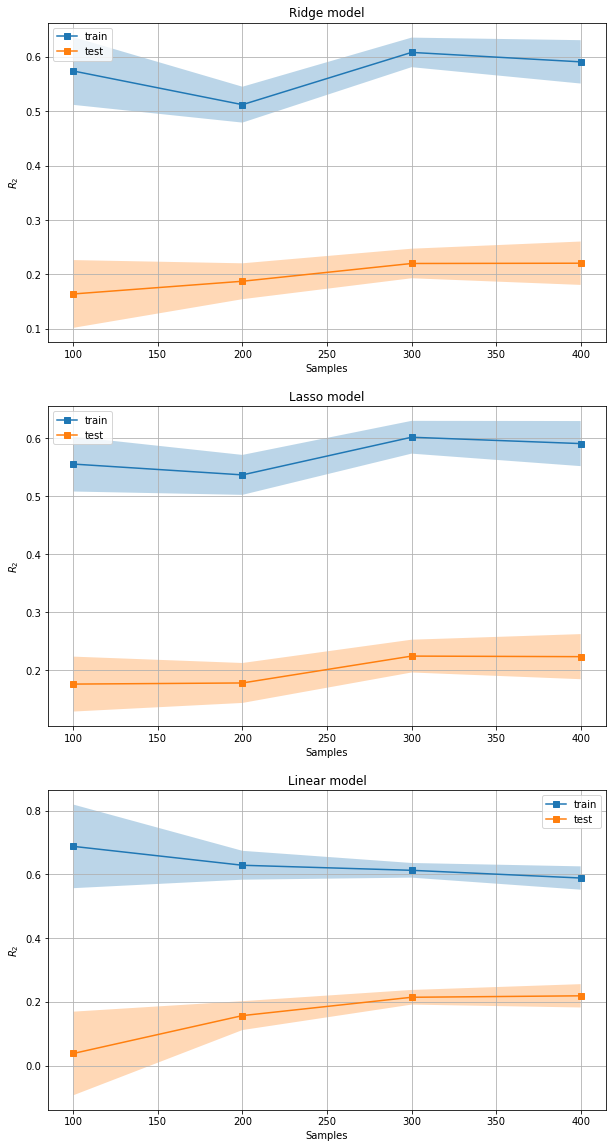

In [94]:
sets = ['train','test']
mname = ['Ridge','Lasso','Linear']
models = [ridge,lasso,linear]
fig,axs = plt.subplots(3,1,figsize=(10,20))

for i,model in enumerate(models):        
    for data_set in sets:
        data = np.array(model[data_set])
        axs[i].plot(samples,data[:,0],'s-',label=data_set)
        axs[i].fill_between(samples,data[:,0]-data[:,1],data[:,0]+data[:,1],alpha=0.3)
        
    axs[i].legend(loc='best')
    axs[i].set_xlabel('Samples')
    axs[i].set_ylabel('$R_2$')
    #axs[i].set_ylim([0,1])
    axs[i].grid(True)
    axs[i].set_title(mname[i]+' '+'model')
    
    

your answers here

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [111]:
# your code here
Xtrain,Xtest,y_train,y_test = sample_data(331)
pol = PolynomialFeatures(4,interaction_only=False)


numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed']
for col in (numerical_columns):
    
    new_cols = [str(col)+'_'+str(x) for x in np.arange(2,5)]
    feat = Xtrain[col].values.reshape(-1,1)
    
    pol.fit(feat)    
    pols = pol.transform(feat)[:,2:]       
    
    df = pd.DataFrame(data=pols,columns=new_cols)
    Xtrain = Xtrain.join(df)
    
    feat = Xtest[col].values.reshape(-1,1)
    pol.fit(Xtest[col].values.reshape(-1,1))    
    pols = pol.transform(feat)[:,2:]       
    df = pd.DataFrame(data=pols,columns=new_cols)
    Xtest = Xtest.join(df)


In [16]:
def make_poly(columns,Xtrain,Xtest):
    for col in columns:
        for x in np.arange(4):
            x+=1
            Xtrain[col+'_'+str(x)] = Xtrain[col]**x
            Xtest[col+'_'+str(x)] = Xtest[col]**x
    return Xtrain,Xtest

In [116]:
#Xtrain,Xtest,y_train,y_test = sample_data(331)
Xtrain_poly = Xtrain
Xtest_poly = Xtest

model = OLS(y_train,Xtrain_poly).fit()

train_pred = model.predict(Xtrain_poly)
test_pred = model.predict(Xtest_poly)
train_score = r2_score(y_train,train_pred)
test_score = r2_score(y_test,test_pred)
print('OLS Train Score: ',train_score)
print('OLS Test Score: ',test_score)

pvalues = model.pvalues
pvalues

OLS Train Score:  0.157171771568
OLS Test Score:  0.0206450241492


holiday            0.034044
workingday         0.339852
temp               0.783949
atemp              0.908997
humidity           0.517687
windspeed          0.531287
season_2.0         0.991241
season_3.0         0.492204
season_4.0         0.035150
month_2.0          0.888519
month_3.0          0.953559
month_4.0          0.064561
month_5.0          0.503013
month_6.0          0.706746
month_7.0          0.632099
month_8.0          0.775344
month_9.0          0.976887
month_10.0         0.622778
month_11.0         0.978044
month_12.0         0.962447
day_of_week_1.0    0.598664
day_of_week_2.0    0.216999
day_of_week_3.0    0.081120
day_of_week_4.0    0.182957
day_of_week_5.0    0.569655
day_of_week_6.0    0.396274
weather_2.0        0.009978
weather_3.0        0.033485
temp_2             0.262517
temp_3             0.312150
temp_4             0.363951
atemp_2            0.142958
atemp_3            0.148964
atemp_4            0.173209
humidity_2         0.654955
humidity_3         0

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [117]:
def make_interactions(Xtrain,Xtest):
    
    pol = PolynomialFeatures(2,interaction_only = True)
    
    Xtrain_int = pol.fit_transform(Xtrain)  
    Xtest_int = pol.fit_transform(Xtest)    
    col_names = pol.get_feature_names(Xtrain.columns)
    
    Xtrain_int= pd.DataFrame(data=Xtrain_int,columns=col_names)
    Xtest_int = pd.DataFrame(data=Xtest_int,columns=col_names)
    return Xtrain_int,Xtest_int

def make_poly2(columns,Xtrain,Xtest):
    Xtrain_poly = pd.DataFrame()
    Xtest_poly = pd.DataFrame()
    for col in columns:
        for x in np.arange(4):
            x+=1
            Xtrain_poly[col+'_'+str(x)] = Xtrain[col]**x
            Xtest_poly[col+'_'+str(x)] = Xtest[col]**x
    return Xtrain_poly,Xtest_poly

def gen_poly(columns,df,k):
    model = PolynomialFeatures(k,include_bias=False)
    df_all_poly = []
    for column in columns:    
        df_poly = df[column]
        df_poly = model.fit_transform(df_poly.values.reshape(-1,1))
        feature_names = model.get_feature_names([column])
        df_poly = pd.DataFrame(data=df_poly[:,1:],columns=feature_names[1:])
        df_all_poly.append(df_poly)
    return df_all_poly

In [118]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

Xtrain,Xtest,y_train,y_test = sample_data(331)
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed']

Xtrain_poly = gen_poly(numerical_columns,Xtrain,4)  
Xtest_poly = gen_poly(numerical_columns,Xtest,4)  

#Xtrain_poly,Xtest_poly = make_poly2(numerical_columns,Xtrain,Xtest)
Xtrain_int,Xtest_int = make_interactions(Xtrain,Xtest)

Xtrain_poly = pd.concat(Xtrain_poly+[Xtrain_int],axis=1)
Xtest_poly = pd.concat(Xtest_poly+[Xtest_int],axis=1)

#Xtrain_poly = Xtrain_poly.join(Xtrain_int)
#Xtest_poly = Xtest_poly.join(Xtest_int)

scaler = MinMaxScaler().fit(Xtrain_poly) 
Xtrain_scaled = scaler.transform(Xtrain_poly)
Xtest_scaled= scaler.transform(Xtest_poly)

components = range(1,30)

for comp in components:
    pca = PCA(n_components = comp)

    Xtrain_pca = pca.fit_transform(Xtrain_scaled)
    Xtest_pca = pca.fit_transform(Xtest_scaled)
    
    model = LinearRegression(fit_intercept = True) #OLS(exog = Xtrain_pca,endog=y_train).fit()
    
            
    tr_score = model.fit(Xtrain_pca,y_train).score(Xtrain_pca,y_train)
    tt_score = model.fit(Xtest_pca,y_test).score(Xtest_pca,y_test)
    
    print('Linear Train Score:',tr_score)
    print('Linear Test Score:',tt_score)
    print('Variance Ratio: ',np.sum(pca.explained_variance_ratio_)*100)
    print('')



Linear Train Score: 0.101707303506
Linear Test Score: 0.0992672503541
Variance Ratio:  13.2769401463

Linear Train Score: 0.114856651395
Linear Test Score: 0.0994335991101
Variance Ratio:  22.2317628637

Linear Train Score: 0.152575899758
Linear Test Score: 0.10497784479
Variance Ratio:  29.4012461529

Linear Train Score: 0.194839231058
Linear Test Score: 0.106115034007
Variance Ratio:  35.2127245433

Linear Train Score: 0.217868161763
Linear Test Score: 0.174275564606
Variance Ratio:  40.0896394724

Linear Train Score: 0.294487263234
Linear Test Score: 0.194136287458
Variance Ratio:  44.5948560235

Linear Train Score: 0.295416289265
Linear Test Score: 0.19572299145
Variance Ratio:  48.8483710369

Linear Train Score: 0.331425740978
Linear Test Score: 0.216661232356
Variance Ratio:  52.7879102384

Linear Train Score: 0.368466308202
Linear Test Score: 0.216866040403
Variance Ratio:  56.1989845256

Linear Train Score: 0.374526412086
Linear Test Score: 0.216876671873
Variance Ratio:  59.43

In [123]:
# your code here
from sklearn.decomposition import TruncatedSVD as SVD

X = Xtrain_scaled
X = X.T.dot(X)
for comp in range(1,30):
    
    svd = SVD(n_components=comp)
    U = svd.fit(X).components_
    new_train = Xtrain_scaled.dot(U.T)
    beta = np.linalg.pinv(new_train).dot(y_train)
    train_pred = new_train.dot(beta)
    
    svd.fit(Xtest_scaled.T.dot(Xtest_scaled))
    U_test = svd.components_
    new_test = Xtest_scaled.dot(U_test.T)
    beta = np.linalg.pinv(new_test).dot(y_test)
    pred = new_test.dot(beta)
    
    print('Test Score: ',r2_score(y_test,pred))
    print('Train Score',r2_score(y_train,train_pred))
    print('Explained Variance: ',np.sum(svd.explained_variance_ratio_)*100)
    print('')


Test Score:  0.0041505242951
Train Score 0.00799607362691
Explained Variance:  82.138655327

Test Score:  0.065194029203
Train Score 0.0566873503836
Explained Variance:  87.9069611738

Test Score:  0.0654892803185
Train Score 0.0696409415852
Explained Variance:  91.2286037968

Test Score:  0.0669245329498
Train Score 0.0826739650037
Explained Variance:  92.6944332692

Test Score:  0.088295148285
Train Score 0.12047330704
Explained Variance:  93.8673018461

Test Score:  0.0949255053802
Train Score 0.146722017378
Explained Variance:  94.7472037274

Test Score:  0.101158894345
Train Score 0.21622666855
Explained Variance:  95.5291669172

Test Score:  0.149750964113
Train Score 0.217244186409
Explained Variance:  96.208615514

Test Score:  0.185047046336
Train Score 0.225589961571
Explained Variance:  96.7444917123

Test Score:  0.186323025139
Train Score 0.295517150984
Explained Variance:  97.2430610445

Test Score:  0.18972447535
Train Score 0.303859526539
Explained Variance:  97.6760935

your answers here


## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [119]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [120]:
# your code here
model = OLS(np.log(np.abs(y_train)+1),Xtrain_poly).fit()
test_pred = model.predict(Xtest_poly)
train_pred = model.predict(Xtrain_poly)
rmsle_log_test = np.sqrt(np.mean(np.square(np.log(np.abs(y_test)+1)-test_pred.values)))
rmsle_log_train = np.sqrt(np.mean(np.square(np.log(np.abs(y_train)+1)-train_pred.values)))

model = OLS(y_train,Xtrain_poly).fit()
test_pred = model.predict(Xtest_poly)
train_pred = model.predict(Xtrain_poly)
rmlse_test = np.sqrt(np.mean(np.square(np.log(np.abs(y_test)+1)-np.log(np.abs(test_pred.values)+1))))
rmlse_train = np.sqrt(np.mean(np.square(np.log(np.abs(y_train)+1)-np.log(np.abs(train_pred.values)+1))))
print('RMLSE for LOG transformed model on test set: ',rmsle_log_test)
print('RMSLE untranformed model on test set: ',rmlse_test)
print('RMLSE for LOG transformed model on training set: ',rmsle_log_train)

print('RMSLE untranformed model on training set: ',rmlse_train)

RMLSE for LOG transformed model on test set:  4.52671694734
RMSLE untranformed model on test set:  1.57723366569
RMLSE for LOG transformed model on training set:  0.4656799538
RMSLE untranformed model on training set:  0.465679952308


your answers here

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

0.042166718319568863

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [ ]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

In [ ]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()